In [22]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# import eli5
from mpl_toolkits import mplot3d 
from sklearn.linear_model import LogisticRegression
import time
from sklearn.manifold import TSNE
# import eli5
# from eli5 import show_weights
# from eli5.sklearnimport PermutationImportance
# import dabl
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 
from sklearn.metrics import classification_report 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}


# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 160 ms


In [2]:
import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "/Users/MyFolders/Aarhus/innvestigate/examples/utils.py")
mnistutils = imp.load_source("utils_mnist", "/Users/MyFolders/Aarhus/innvestigate/examples/utils_mnist.py")

time: 212 ms


In [3]:
netcdf_path = (PROJ_PATH / 'internship'/'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 679 ms


In [4]:
ds.close()

time: 140 ms


In [5]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns= ['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 21.4 s


In [6]:
class_names = []

time: 157 ms


In [7]:
def req_clf(satellite_type):
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-01-01', '2019-12-31'), 
                                fields='all', 
                                satellite=satellite_type, 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'
    
    mapping = {
    0: 'Potato',
    1: 'Spring barley',
    2: 'Winter barley',
    3: 'Spring wheat',
    4: 'Winter wheat',
    5: 'Winter rye',
    6: 'Spring oat',
    7: 'Maize',
    8: 'Rapeseed',
    9: 'Permanent grass',
    10: 'Willow',
    11: 'Forest'
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Fit to training data and then scale training data
    X_test = scaler.transform(X_test) 
    return df_sklearn, df_sklearn_remapped, class_names, X_train, y_train, X_test, y_test

time: 161 ms


In [8]:
df_sklearn, df_sklearn_remapped, class_names, X_train, y_train, X_test, y_test = req_clf("S1A")

time: 37.7 s


In [9]:
df_sklearn_remapped.head()

,field_id,afgkode,afgroede,Crop type,Label ID,2018-07-14_VV,2018-07-26_VV,2018-08-07_VV,2018-08-19_VV,2018-08-31_VV,...,2019-07-09_VV-VH,2019-07-21_VV-VH,2019-08-02_VV-VH,2019-08-14_VV-VH,2019-08-26_VV-VH,2019-09-07_VV-VH,2019-09-19_VV-VH,2019-10-01_VV-VH,2019-10-13_VV-VH,2019-10-25_VV-VH
0,61853445,151,"Kartofler, stivelses-",Potato,0,-12.891666,-13.612904,-13.682540,-11.891473,-11.258620,...,8.652892,7.348214,6.983333,6.656934,6.044117,7.210526,5.927419,7.170732,8.984962,11.775194
1,61952339,151,"Kartofler, stivelses-",Potato,0,-13.538243,-14.758087,-15.727401,-11.352610,-11.239775,...,6.661992,6.522599,7.116573,6.836620,6.303116,6.055241,4.859155,5.771389,5.427157,6.018207
2,61952436,151,"Kartofler, stivelses-",Potato,0,-10.658731,-16.452381,-16.307087,-12.344000,-12.928572,...,5.944882,4.976000,6.682539,5.307086,5.272000,4.384000,5.746032,8.700788,8.666667,8.755905
3,61952337,151,"Kartofler, stivelses-",Potato,0,-12.409185,-16.343815,-15.752621,-12.390295,-12.613108,...,6.700000,6.629707,7.605042,6.739407,6.502092,6.121086,5.948240,5.305907,5.500000,6.834395
4,61952348,151,"Kartofler, stivelses-",Potato,0,-13.537199,-16.214518,-16.474836,-13.230853,-13.928416,...,6.761697,6.119126,6.825327,6.591748,6.387202,6.037037,4.914317,5.104689,5.631808,5.346783


time: 165 ms


In [10]:
feature_names = df_sklearn_remapped.columns[5:]

time: 81.1 ms


In [11]:
num_classes = 12
feature_vector_length = X_train.shape[1]
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

time: 85.6 ms


In [12]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(30, input_shape=input_shape, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Feature shape: (114,)
time: 223 ms


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                3450      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                372       
Total params: 4,752
Trainable params: 4,752
Non-trainable params: 0
_________________________________________________________________
time: 102 ms


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_encoded, epochs=10)

Epoch 1/10
31051/31051 [==============================] - 2s 77us/step - loss: 0.5752 - acc: 0.8394
Epoch 2/10
31051/31051 [==============================] - 2s 59us/step - loss: 0.3306 - acc: 0.9119
Epoch 3/10
31051/31051 [==============================] - 2s 77us/step - loss: 0.2991 - acc: 0.9214
Epoch 4/10
31051/31051 [==============================] - 2s 63us/step - loss: 0.2818 - acc: 0.9256: 0s - loss: 0.2799 -
Epoch 5/10
31051/31051 [==============================] - 2s 62us/step - loss: 0.2706 - acc: 0.9293
Epoch 6/10
31051/31051 [==============================] - 3s 100us/step - loss: 0.2622 - acc: 0.9317
Epoch 7/10
31051/31051 [==============================] - 3s 102us/step - loss: 0.2560 - acc: 0.9325
Epoch 8/10
31051/31051 [==============================] - 3s 101us/step - loss: 0.2502 - acc: 0.9337
Epoch 9/10
31051/31051 [==============================] - 3s 89us/step - loss: 0.2456 - acc: 0.9359
Epoch 10/10
31051/31051 [==============================] - 2s 55us/step - lo

time: 25.2 s


In [15]:
train_results = model.evaluate(X_train, y_train_encoded, verbose=1)
print(f'Train results - Loss: {train_results[0]} - Accuracy: {train_results[1]}%')

31051/31051 [==============================] - 1s 22us/step
Train results - Loss: 0.22459066299892141 - Accuracy: 0.941322340665357%
time: 783 ms


In [16]:
test_results = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

13308/13308 [==============================] - 0s 19us/step
Test results - Loss: 0.3084295056110877 - Accuracy: 0.9239555154794109%
time: 339 ms


In [19]:
class_names

['Potato',
 'Spring barley',
 'Winter barley',
 'Spring wheat',
 'Winter wheat',
 'Winter rye',
 'Spring oat',
 'Maize',
 'Rapeseed',
 'Permanent grass',
 'Willow',
 'Forest']

time: 95 ms


In [33]:
predictions = model.predict_classes(X_test)

time: 239 ms


In [ ]:
from keras.utils import np_utils
x_vec = np_utils.to_categorical(x, nb_classes)

# class vector --> class 
x = x_vec.argmax(axis=-1)

In [26]:
y_test.shape

(13308,)

time: 96.5 ms


In [39]:
predictions = model.predict_classes(X_test)
results_report = classification_report(y_test, predictions, target_names=class_names)
print("\n", results_report)


                  precision    recall  f1-score   support

         Potato       0.98      0.98      0.98      2321
  Spring barley       0.88      0.86      0.87      1153
  Winter barley       0.97      0.96      0.96      1342
   Spring wheat       0.70      0.57      0.63       449
   Winter wheat       0.91      0.95      0.93      1107
     Winter rye       0.94      0.95      0.94      1279
     Spring oat       0.86      0.86      0.86      1302
          Maize       0.96      0.96      0.96      1507
       Rapeseed       0.99      0.99      0.99      1103
Permanent grass       0.87      0.93      0.90      1140
         Willow       0.84      0.79      0.81       233
         Forest       0.87      0.88      0.88       372

       accuracy                           0.92     13308
      macro avg       0.90      0.89      0.89     13308
   weighted avg       0.92      0.92      0.92     13308

time: 377 ms


In [63]:
result = np.where((y_test == 6))
req_indices = result[0]
req_indices = list(req_indices)
test_results = model.evaluate(X_test[req_indices], y_test_encoded[req_indices], verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

1302/1302 [==============================] - 0s 25us/step
Test results - Loss: 0.4690234366283622 - Accuracy: 0.8725038399710999%
time: 121 ms


In [48]:
empty_array_zero = np.empty((0, 114), int)
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("lrp.z", model_wo_sm)
for i in range(X_test.shape[0]):
    analysis = analyzer.analyze(X_test[i].reshape(1,114))
    empty_array_zero = np.append(empty_array_zero, analysis, axis=0)
    
empty_array_zero.shape

(13308, 114)

time: 52.5 s


In [50]:
mapping = {
0: 'Potato',
1: 'Spring barley',
2: 'Winter barley',
3: 'Spring wheat',
4: 'Winter wheat',
5: 'Winter rye',
6: 'Spring oat',
7: 'Maize',
8: 'Rapeseed',
9: 'Permanent grass',
10: 'Willow',
11: 'Forest'
}

crop_tonumber = {
    'Potato': 0,
    'Spring barley': 1,
    'Winter barley': 2,
    'Spring wheat': 3,
    'Winter wheat': 4,
    'Winter rye': 5,
    'Spring oat': 6,
    'Maize': 7,
    'Rapeseed': 8,
    'Permanent grass': 9,
    'Willow': 10,
    'Forest': 11
}

# crop_tonumber = {
#     'Potato': 0,
#     'Spring barley': 1,
#     'Winter barley': 2,
#     'Spring wheat': 3,
#     'Winter wheat': 4,
#     'Winter rye': 5,
#     'Spring oat': 6,
#     'Maize': 7,
#     'Rapeseed': 8,
#     'Permanent grass': 9,
#     'Willow': 10,
#     'Forest': 11
# }

time: 83.4 ms


In [51]:
def convert_df(df_explanation):
    df_explanation['polarization'] = ''
    features = df_explanation['feature'].unique()
    features = features[:-1]  # The last features are the bias values
    df_bias_values = df_explanation[df_explanation['feature'] == '<BIAS>']

    df_explanation = df_explanation[df_explanation['feature'] != '<BIAS>']
    for feature in features:
        if feature[-5:] == 'VV-VH':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
            df_explanation = df_explanation.replace(feature, feature[:-6])
        elif feature[-2:] == 'VV':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
            df_explanation = df_explanation.replace(feature, feature[:-3])
        else:
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
            df_explanation = df_explanation.replace(feature, feature[:-3])

    return df_explanation

time: 84.6 ms


In [52]:
def mlp_explanation(croptype, empty_array):
    df_explanation = pd.DataFrame(data = empty_array, columns = feature_names)
    crop_number = crop_tonumber[croptype]
    result = np.where((y_test == crop_number))
    req_indices = result[0]
    req_indices = list(req_indices)
    df_explanation = df_explanation.iloc[req_indices]
    averaged_explanation = df_explanation.mean(axis=0).to_frame().reset_index()
    averaged_explanation.rename(columns={"index": "feature", 0: "weight"}, inplace = True)
    df_explanation = convert_df(averaged_explanation)
    df_explanation = df_explanation.sort_values(by=['feature','polarization'])
    data = df_explanation.loc[df_explanation['polarization'].isin(['VV', 'VH', 'VV-VH'])]
    #data = data.loc[data['target'].isin(['Forest', 'Rapeseed'])]
    plt.figure(figsize=(13, 4))
    plt.xticks(rotation=90, horizontalalignment = 'center')
    sns.set_context("talk")
    ax = sns.lineplot(x='feature', y='weight', hue='polarization', data=data, ci='sd')

time: 79.8 ms


# LRP-ZERO 

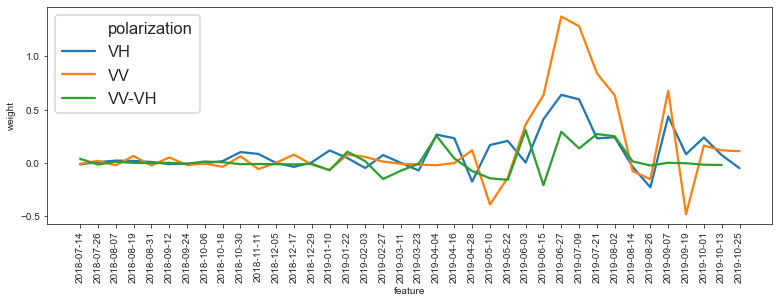

time: 1.09 s


In [26]:
mlp_explanation("Potato", empty_array_zero)

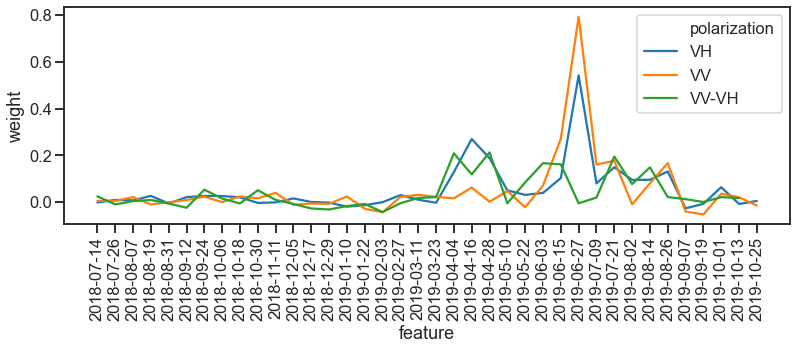

time: 995 ms


In [32]:
mlp_explanation("Spring barley", empty_array_zero)

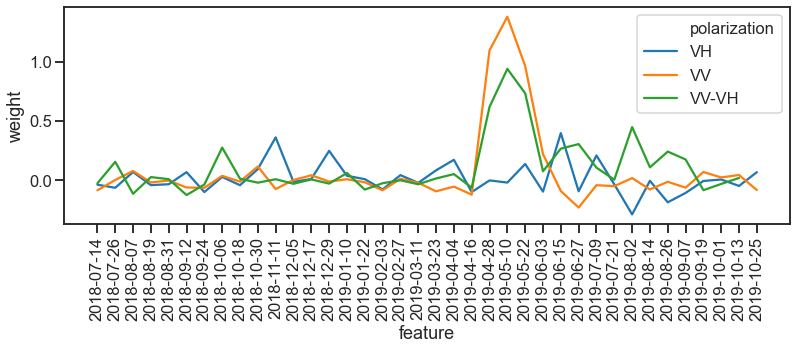

time: 931 ms


In [33]:
mlp_explanation("Winter barley", empty_array_zero)

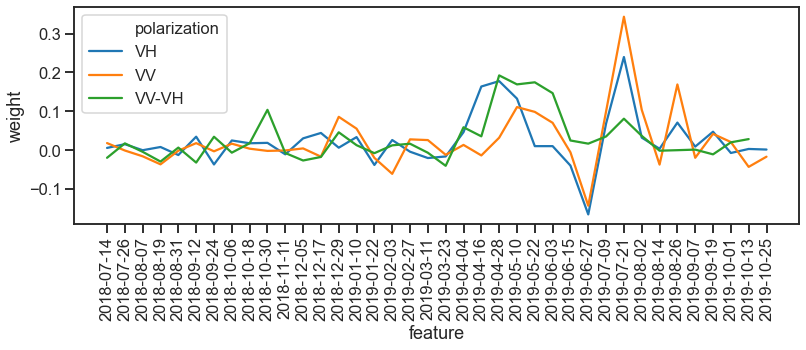

time: 886 ms


In [27]:
mlp_explanation("Spring wheat", empty_array_zero)

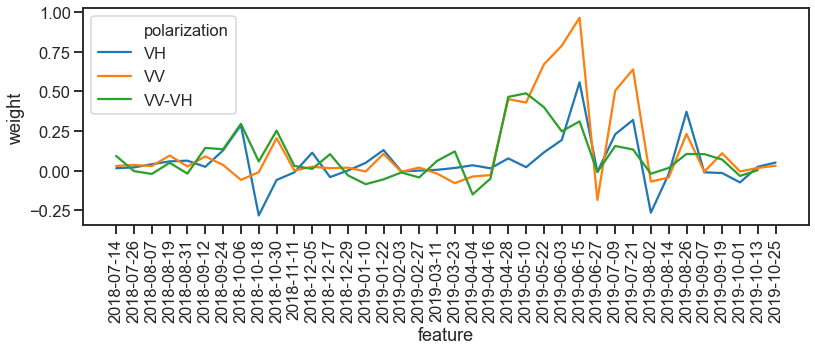

time: 976 ms


In [129]:
mlp_explanation("Winter wheat", empty_array_zero)

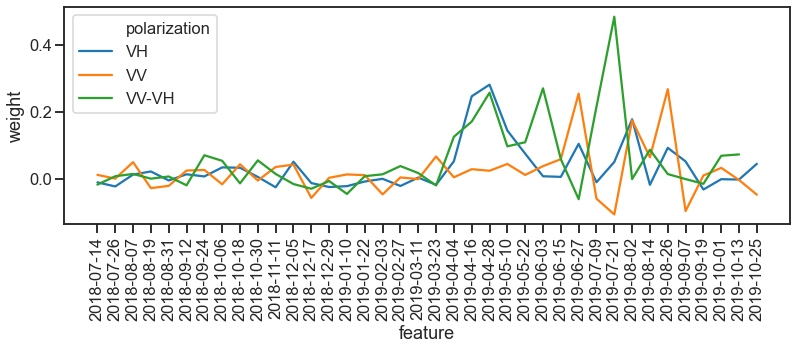

time: 903 ms


In [41]:
mlp_explanation("Spring oat", empty_array_zero)

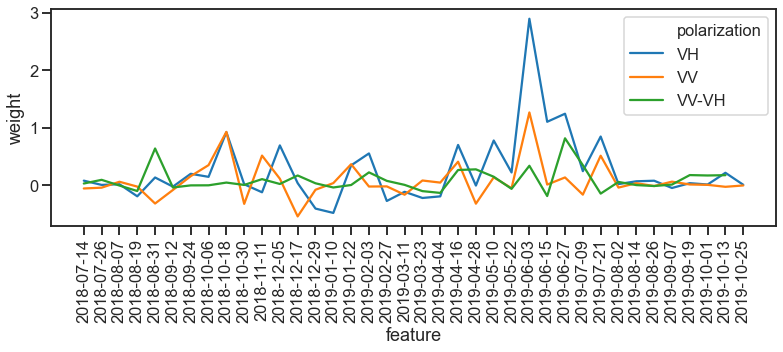

time: 1.01 s


In [40]:
mlp_explanation("Rapeseed", empty_array_zero)

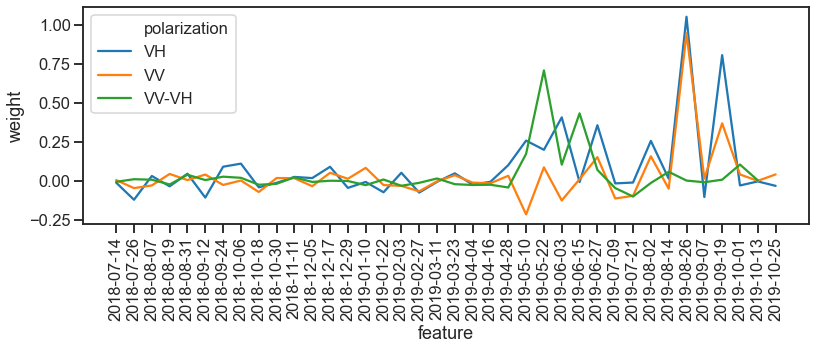

time: 1.01 s


In [37]:
mlp_explanation("Maize", empty_array_zero)

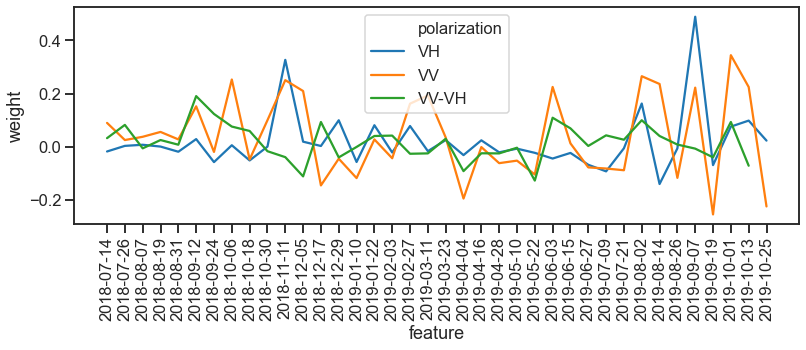

time: 901 ms


In [38]:
mlp_explanation("Permanent grass", empty_array_zero)

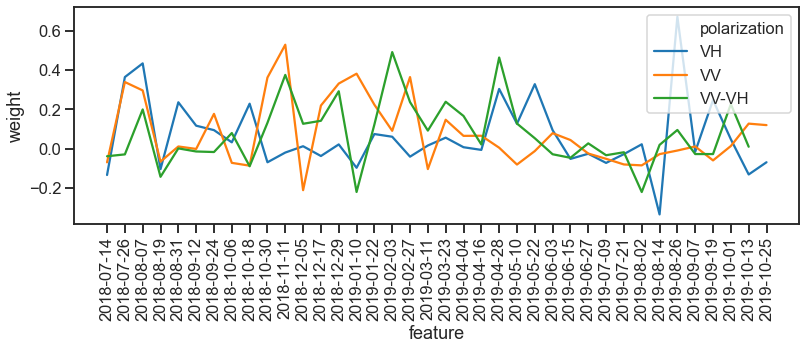

time: 1.03 s


In [39]:
mlp_explanation("Willow", empty_array_zero)

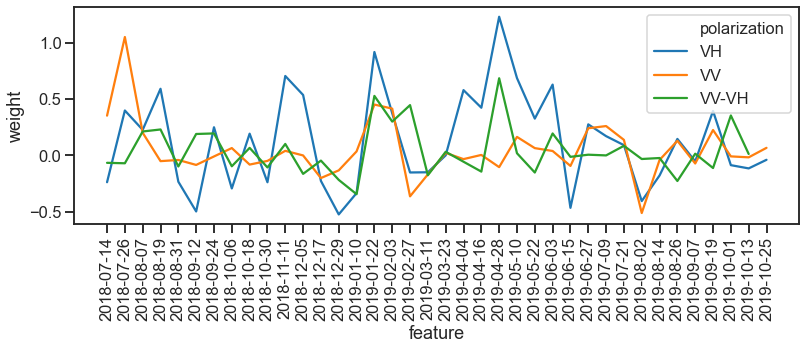

time: 1.06 s


In [29]:
mlp_explanation("Forest", empty_array_zero)

# LRP-Alpha1Beta0

In [30]:
empty_array_ab = np.empty((0, 114), int)
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("lrp", model_wo_sm, rule = ["Z", "Z"], input_layer_rule = "Alpha1Beta0")
for i in range(X_test.shape[0]):
    analysis = analyzer.analyze(X_test[i].reshape(1,114))
    empty_array_ab = np.append(empty_array_ab, analysis, axis=0)

time: 53.3 s


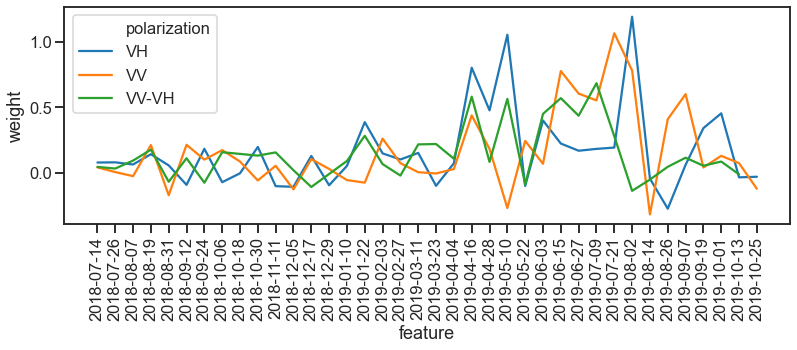

time: 958 ms


In [133]:
mlp_explanation("Potato", empty_array_ab)

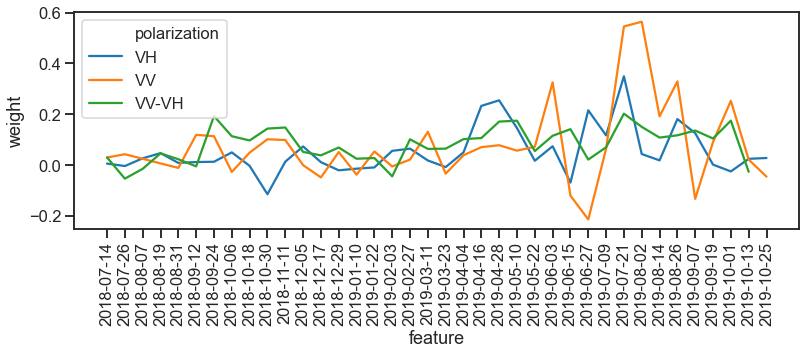

time: 954 ms


In [134]:
mlp_explanation("Spring wheat", empty_array_ab)

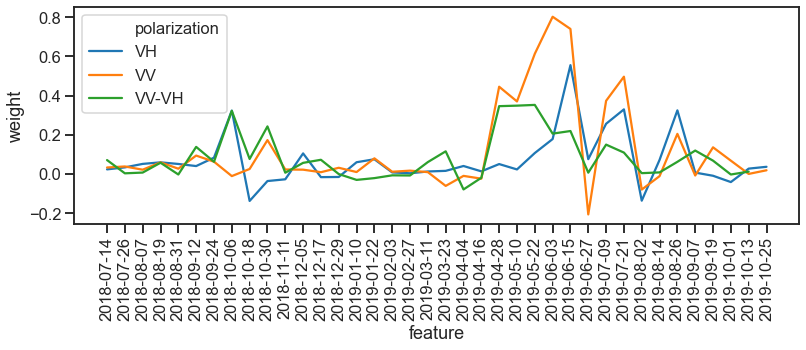

time: 1.42 s


In [135]:
mlp_explanation("Winter wheat", empty_array_ab)

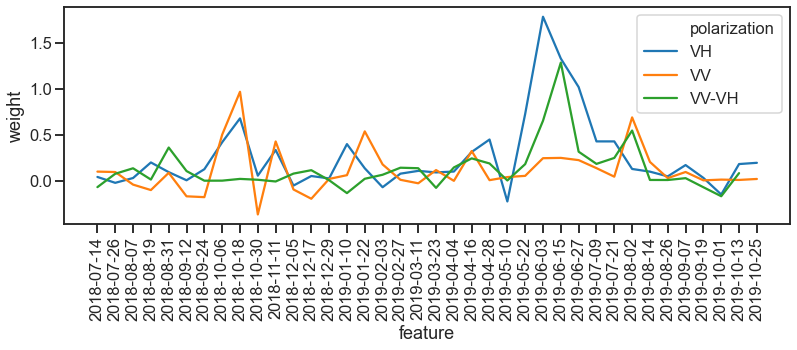

time: 893 ms


In [136]:
mlp_explanation("Rapeseed", empty_array_ab)

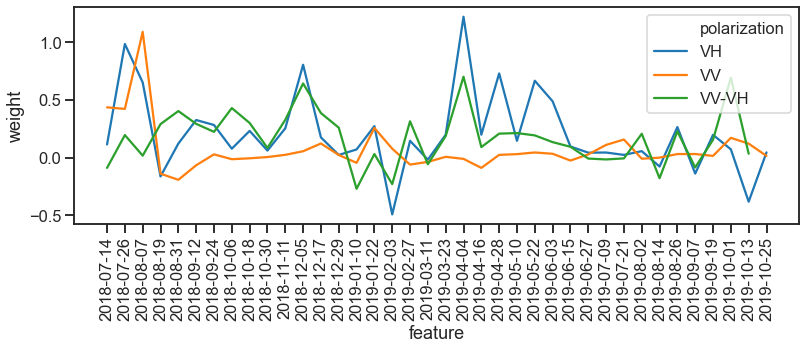

time: 1.16 s


In [137]:
mlp_explanation("Forest", empty_array_ab)

# LRP-Alpha2Beta1

In [138]:
empty_array_a2b1 = np.empty((0, 114), int)
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("lrp", model_wo_sm, rule = ["Z", "Z"], input_layer_rule = "Alpha2Beta1")
for i in range(X_test.shape[0]):
    analysis = analyzer.analyze(X_test[i].reshape(1,114))
    empty_array_a2b1 = np.append(empty_array_a2b1, analysis, axis=0)

time: 12.8 s


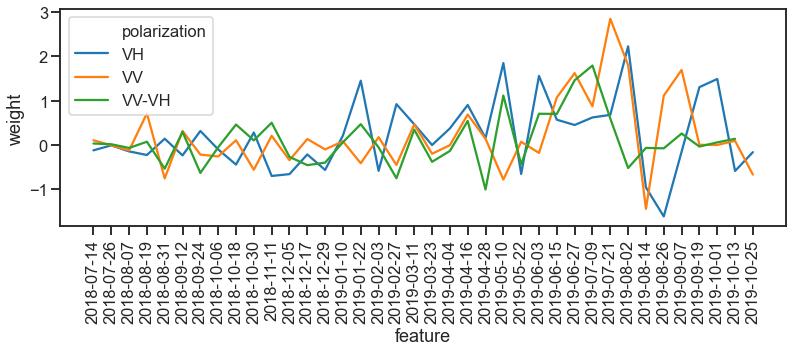

time: 978 ms


In [139]:
mlp_explanation("Potato", empty_array_a2b1)

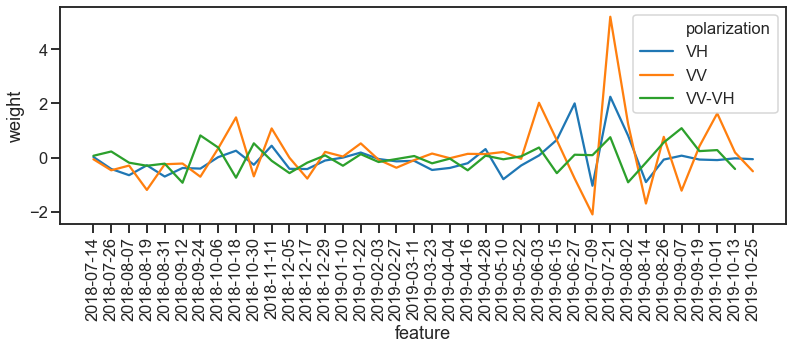

time: 1.05 s


In [140]:
mlp_explanation("Spring wheat", empty_array_a2b1)

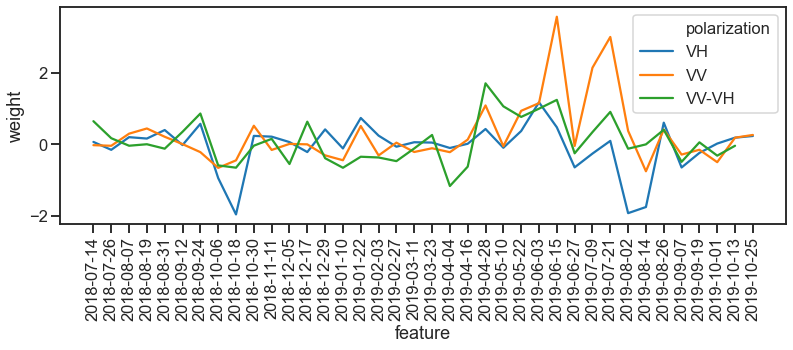

time: 990 ms


In [142]:
mlp_explanation("Winter wheat", empty_array_a2b1)

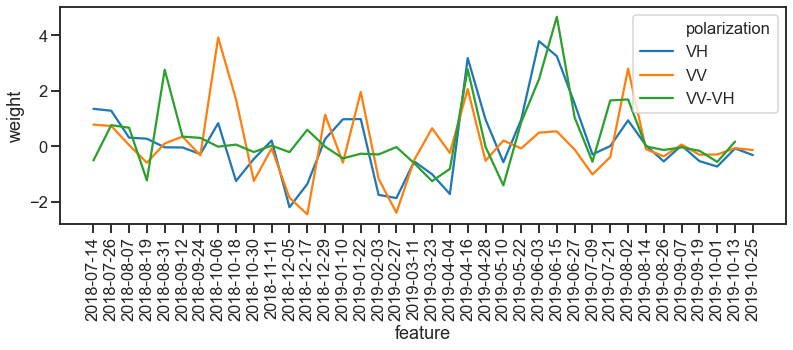

time: 973 ms


In [143]:
mlp_explanation("Rapeseed", empty_array_a2b1)